<a href="https://colab.research.google.com/github/FrancescoTorella/progettoLabAI/blob/main/Presentazione.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Premessa:
Il dataset con cui avevo a che fare conteneva immagini 900x900, troppo grandi per essere elaborate direttamente dalla GPU di colab (ottenevo un errore: "CUDA Out of memory). Di conseguenza negli addestramenti ho dovuto effettuare un resizing a 300x300 oppure un cropping sempre a 300x300, un altro approccio che ho seguito è stato quello di sezionare le immagini in 9 pezzi 300x300 creando in pratica un altro dataset, questo mi ha permesso anche di eliminare quelle "strisce nere" presenti in molte immagini. I risultati con questo nuovo dataset erano anche buoni, però essendo più grande i tempi per il training erano decisamente maggiori e ho preferito utilizzare altri approcci meno costosi considerando le risorse a pagamento limitate di google colab.

In [ ]:
!pip install rasterio
import torch
import torchvision
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms.functional as TF
import os
import rasterio
from PIL import Image
from torch.utils.data import Dataset
import numpy as np
from torch.utils.data import DataLoader
import shutil
import matplotlib.pyplot as plt
import time
import random
from sklearn.metrics import precision_score, recall_score, f1_score
from google.colab import drive
drive.mount('/content/drive')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 21.4 MB/s eta 0:00:00
Mounted at /content/drive


In [ ]:
TRAIN_IMG_DIR = "/content/drive/MyDrive/progettoLabAi3/train/PS-RGBNIR/train_set"
TRAIN_MASK_DIR = "/content/drive/MyDrive/progettoLabAi3/train/mask/train_set"
VAL_IMG_DIR = "/content/drive/MyDrive/progettoLabAi3/train/PS-RGBNIR/val_set"
VAL_MASK_DIR = "/content/drive/MyDrive/progettoLabAi3/train/mask/val_set"

##Osservazioni su immagini

Per la tesina ho scelto remote sensing e il task di image segmentation, ho lavorato con le immagini RGBNIR, ovvero immagini che oltre ai classici tre canali RGB hanno un quarto canale NIR. Eccone alcuni esempi:

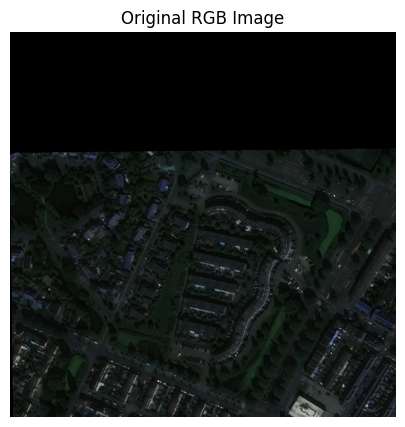

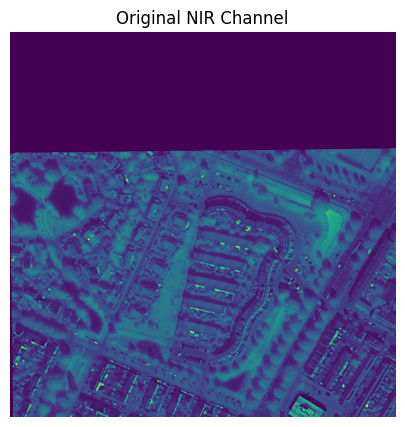

In [ ]:

# Funzione per caricare e normalizzare un'immagine
def load_mask(img_path):
    with rasterio.open(img_path) as src:
      img = src.read()
    GRAY = img[0]
    #NIR = img[3]
    return GRAY


def load_and_normalize_image(img_path):
    with rasterio.open(img_path) as src:
        img = src.read()
    R = img[0]
    G = img[1]
    B = img[2]
    NIR = img[3]
    return normalize(R), normalize(G), normalize(B), normalize(NIR)




# Funzione per normalizzare i valori dei pixel
def normalize(channel):
    channel_min, channel_max = channel.min(), channel.max()
    return (channel - channel_min) / (channel_max - channel_min)


def print_random_image(input_dir,title = "Image"):

    random_image = random.choice([f for f in os.listdir(input_dir) if f.endswith('.tif')])

    img_path = os.path.join(input_dir, random_image)
    plt.figure(figsize=(10, 5))
    plt.imshow(img_path)
    plt.title(title)
    plt.axis('off')
    plt.show()

# Visualizza le immagini
def show_image(rgb, title):
    plt.figure(figsize=(10, 5))
    plt.imshow(rgb)
    plt.title(title)
    plt.axis('off')
    plt.show()



def main():
    random_image = random.choice([f for f in os.listdir(TRAIN_IMG_DIR) if f.endswith('.tif')])
    img_path = os.path.join(TRAIN_IMG_DIR, random_image)

    R_original, G_original, B_original, NIR_original = load_and_normalize_image(img_path)
    rgb_original = np.dstack((R_original, G_original, B_original))
    show_image(rgb_original, 'Original RGB Image')

    show_image(NIR_original, 'Original NIR Channel')


if __name__ == "__main__":
  main()

##Splitting del dataset
Questa è la funzione con cui ho diviso il dataset, i di ciascun file sono divisi in tre file txt, successivamente ho eseguito uno spsotamento di quei file tramite uno script python. Lo splitting che avevo fatto è 70, 15, 15

In [ ]:
def split_dataset(image_dir, output_dir, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15, seed=42):
    # Imposta il seed per la riproducibilità
    random.seed(seed)

    # Lista di tutte le immagini
    images = [f for f in os.listdir(image_dir) if f.endswith('.tif')]

    # Suddivisione train/val/test
    train_and_val, test = train_test_split(images, test_size=test_ratio, random_state=seed)
    train, val = train_test_split(train_and_val, test_size=val_ratio / (train_ratio + val_ratio), random_state=seed)

    # Salva i percorsi nei file .txt
    os.makedirs(output_dir, exist_ok=True)
    with open(os.path.join(output_dir, 'train.txt'), 'w') as f:
        for item in train:
            f.write("%s\n" % item)
    with open(os.path.join(output_dir, 'val.txt'), 'w') as f:
        for item in val:
            f.write("%s\n" % item)
    with open(os.path.join(output_dir, 'test.txt'), 'w') as f:
        for item in test:
            f.write("%s\n" % item)

##Conversione file geojson
Le maschere si presentavano in formato geojson e andavano convertite, la mia funzione di correzione fa uso delle immagini rgb originali e della libreria geopandas per effettuare la conversione. Stampiamo alcuni esempi:

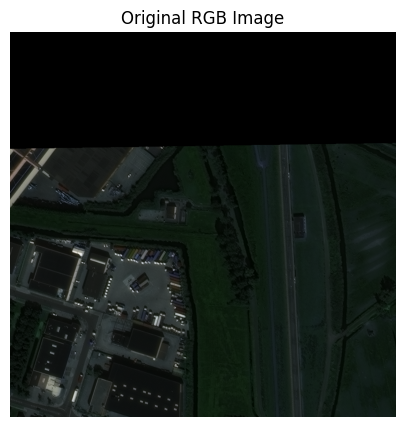

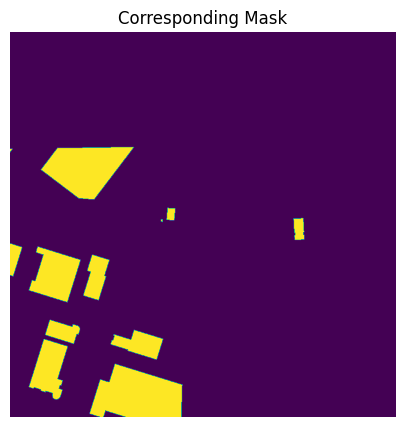

In [ ]:
def main():
    random_image = random.choice([f for f in os.listdir(TRAIN_IMG_DIR) if f.endswith('.tif')])
    img_path = os.path.join(TRAIN_IMG_DIR, random_image)

    mask_path = os.path.join(TRAIN_MASK_DIR, random_image.replace("PS-RGBNIR","Buildings").replace(".tif","_mask.tiff"))

    mask = load_mask(mask_path)
    R_original, G_original, B_original, NIR_original = load_and_normalize_image(img_path)
    rgb_original = np.dstack((R_original, G_original, B_original))
    show_image(rgb_original, 'Original RGB Image')

    show_image(mask, "Corresponding Mask")


if __name__ == "__main__":
  main()

##Definizione della classe dataset
In questo codice ho esteso la classe dataset:


In [ ]:
class MultispectralDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = os.listdir(image_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img_path = os.path.join(self.image_dir, self.images[index])
        string = self.images[index]
        mask_name = string.replace('PS-RGBNIR','Buildings').replace(".tif","_mask.tiff")
        #print("STRINGA"+ string)
        #tile_index= indice_numero = max(string.rfind('_'), string.rfind(' '))
        #mask_name = string[:tile_index + 1] + "mask_" + string[tile_index + 1:]
        #print("FINALE: "+ mask_name)
        #mask_name = mask_name.replace("11 mask_2.tiff","mask_11.tiff")
        #mask_name = mask_name.replace("12 mask_2.tiff","mask_12.tiff")
        #mask_name = mask_name.replace("13 mask_2.tiff","mask_23.tiff")
        #mask_name = mask_name.replace("21 mask_2.tiff","mask_21.tiff")
        #mask_name = mask_name.replace("22 mask_2.tiff","mask_22.tiff")
        #mask_name = mask_name.replace("23 mask_2.tiff","mask_23.tiff")
        #mask_name = mask_name.replace("31 mask_2.tiff","mask_31.tiff")
        #mask_name = mask_name.replace("32 mask_2.tiff","mask_32.tiff")
        #mask_name = mask_name.replace("33 mask_2.tiff","mask_33.tiff")
        mask_path = os.path.join(self.mask_dir, mask_name)
        with rasterio.open(img_path) as src:
            image = src.read().transpose((1, 2, 0)).astype(np.float32)
        with rasterio.open(mask_path) as src:
          mask = src.read().astype(np.float32)

        mask[mask == 255.0] = 1.0
        mask = mask.squeeze(0)

        if self.transform is not None:
            augmentations = self.transform(image=image, mask=mask)
            image = augmentations["image"]
            mask = augmentations["mask"]


        return image, mask

##Definizione del Modello
Ci era stato consigliato di seguire un tutorial per implementare il modello, esso è un modello tipico per i problemi di segmentazione: implementa una rete neurale convoluzionale con un'uscita grande quanto l'immagine di ingresso, ma con un solo canale, la struttura è simile a quella descritta a lezione.


In [ ]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

class UNET(nn.Module):
    def __init__(
            self, in_channels=3, out_channels=1, features=[64, 128, 256, 512],
    ):
        super(UNET, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part of UNET
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part of UNET
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2,
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)

##Funzioni di utility
In questa sezione ho definito alcune funzioni di utility, ad esempio il salvataggio del modello, il ripristio di un modello precedente, il calcolo delle statistiche e il salvataggio delle predictions.

In [ ]:

def save_checkpoint(state, filename="/content/drive/My Drive/progettoLabAi3/computations/saved/my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)

def load_checkpoint(checkpoint, model):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])

def check_accuracy(loader, model, loss_fn, file,device="cuda"):
    model.eval()
    num_correct = 0
    num_pixels = 0
    dice_score = 0
    precision = 0
    recall = 0
    f1 = 0
    val_loss = 0
    iteration = 1
    print(f'interations: {len(loader)}')
    with torch.no_grad():
        for x, y in loader:
            print(f'Iteration number: {iteration}')

            iteration += 1


            x = x.to(device)
            y = y.to(device).unsqueeze(1)

            out = model(x)
            val_loss += loss_fn(out, y).item()
            preds = torch.sigmoid(out)
            preds = (preds > 0.5)
            num_correct += (preds == y).sum()
            num_pixels += torch.numel(preds)
            dice_score += (2 * (preds * y).sum()) / ((preds + y).sum() + 1e-8)
            precision += precision_score(y.cpu().numpy().flatten(), preds.cpu().numpy().flatten(), zero_division=1)
            recall += recall_score(y.cpu().numpy().flatten(), preds.cpu().numpy().flatten(), zero_division=1)
            f1 += f1_score(y.cpu().numpy().flatten(), preds.cpu().numpy().flatten(), zero_division=1)



    denominator = len(loader)

    val_loss /= denominator
    accuracy = num_correct / num_pixels * 100
    dice = dice_score / denominator
    precision_avg = precision / denominator
    recall_avg = recall / denominator
    f1_avg = f1 / denominator

    print(f"Validation Loss: {val_loss:.4f}")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Dice score: {dice}")
    print(f"Precision: {precision_avg}")
    print(f"Recall: {recall_avg}")
    print(f"F1 Score: {f1_avg}")

    # Salva i risultati su un file di testo
    with open(file, "a") as f:
        f.write(f"Validation Loss: {val_loss:.4f}\n")
        f.write(f"Accuracy: {accuracy:.2f}\n")
        f.write(f"Dice score: {dice}\n")
        f.write(f"Precision: {precision_avg}\n")
        f.write(f"Recall: {recall_avg}\n")
        f.write(f"F1 Score: {f1_avg}\n")
        f.write("\n")  # Riga vuota per separare le epoche

    model.train()


def save_predictions_as_imgs(loader, model, folder="/content/drive/My Drive/progettoLabAi3/computations/saved/images/",
                             device="cuda"):
    model.eval()  # Imposta il modello in modalità di valutazione
    print(f"Saving images to {folder}")
    iteration = 1
    for idx, (x, y) in enumerate(loader):
        print("Iteration: ", iteration)
        iteration += 1
        x = x.to(device=device)
        y = y.to(device=device).unsqueeze(1)
        with torch.no_grad():
            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()

        # Concatenare le immagini (maschera originale e predizione) lungo l'asse verticale
        combined = torch.cat((y, preds), dim=2)

        # Salvare l'immagine combinata
        torchvision.utils.save_image(combined, f"{folder}/comparison_{idx}.png")

    model.train()  # Ripristina il modello in modalità di addestramento


def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

def write_description(description, file):
  with open(file, "a") as f:
    f.write(f"Descrizione: {description}\n\n\n\n")

##Main

Questo è il loop di training

In [ ]:
# Hyperparameters etc.
LEARNING_RATE = 1e-4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 16
NUM_EPOCHS = 20
NUM_WORKERS = 4
IMAGE_HEIGHT = 300
IMAGE_WIDTH = 300
STEP_SIZE = 18
PIN_MEMORY = True
LOAD_MODEL = False
TRAIN_IMG_DIR = "/content/images/train_set"
TRAIN_MASK_DIR = "/content/mask/train_set"
VAL_IMG_DIR = "/content/images/val_set"
VAL_MASK_DIR = "/content/mask/val_set"
TEST_IMG_DIR = "/content/images/test_set"
TEST_MASK_DIR =  "/content/mask/test_set"
MODEL_DIRECTORY = "/content/drive/My Drive/progettoLabAi3/computations/saved/model15/"
MODEL_DESCRIPTION = "modello identico al primo ma con la media e varianza calcolate da me"


def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)


def train_fn(loader, model, optimizer, loss_fn, scaler,file):
    loop = tqdm(loader)

    for batch_idx, (data, targets) in enumerate(loop):

        data = data.to(device=DEVICE)
        targets = targets.float().to(device=DEVICE)

        with torch.cuda.amp.autocast():
            predictions = model(data).squeeze(1)
            loss = loss_fn(predictions, targets)

        # backward
        optimizer.zero_grad() #azzera i gradienti
        scaler.scale(loss).backward() #calcola i gradienti e scala i gradienti
        scaler.step(optimizer) #aggiorna i pesi
        scaler.update() #descala i pesi


        loop.set_postfix(loss=loss.item())
        last_loss = loss.item()  # Memorizza l'ultima loss calcolata


    with open(file, "a") as f:
        f.write(f"Train Loss: {last_loss:.4f}\n")



def main():

    set_seed(42)

    print("Creo le trasformazioni")
    train_transform = A.Compose(
        [
            A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
            #A.CenterCrop(height=896,width=896),
            #A.RandomCrop(height=320,width=320),
            #A.Rotate(limit=90, p=0.5),
            #A.HorizontalFlip(p=0.5),
            #A.VerticalFlip(p=0.5),
            A.Normalize(
                #mean=[84.882515, 114.9725, 122.400505, 264.03476],
                #std=[112.35377, 132.05618, 154.0384, 294.54465],
                mean=[0.0, 0.0, 0.0, 0.0],
                std=[1.0, 1.0, 1.0, 1.0],
                #max_pixel_value=65535.0,
            ),
            ToTensorV2(),
        ],
    )
    val_transforms = A.Compose(
        [
            A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
            #A.CenterCrop(height=896,width=896),
            #A.RandomCrop(height=320,width=320),
            A.Normalize(
                #mean=[81.27881, 111.04898, 117.07683, 261.56107],
                #std=[110.35951, 129.69858, 151.043, 296.55923],
                mean=[0.0, 0.0, 0.0, 0.0],
                std=[1.0, 1.0, 1.0, 1.0],
                #max_pixel_value=65535.0,
            ),
            ToTensorV2(),
        ],
    )

    write_description(MODEL_DESCRIPTION, file= MODEL_DIRECTORY +"outputs/outputs.txt")

    print("Creazione modello ...")
    model = UNET(in_channels=4, out_channels=1).to(DEVICE)
    print("Modelo creato !")
    print("Creo loss, ottimizzatore e scheduler ...")
    loss_fn = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE)
    print("loss, ottimizzatore e scheduler creati con successo !")

    print("Creazione data loaders  e dataset ...")
    train_loader, val_loader = get_loaders(
        TRAIN_IMG_DIR,
        TRAIN_MASK_DIR,
        VAL_IMG_DIR,
        VAL_MASK_DIR,
        BATCH_SIZE,
        train_transform,
        val_transforms,
        NUM_WORKERS,
        PIN_MEMORY,
    )
    print("Data loaders creati correttamente !")


    print("Caricamento modello dal checkpoint ...")
    if LOAD_MODEL:
        load_checkpoint(torch.load(MODEL_DIRECTORY +"my_checkpoint.pth.tar"), model)
    print("Checkpoint caricato con successo !")


    scaler = torch.cuda.amp.GradScaler()

    print("Ciclo di addestramento ...")
    for epoch in range(NUM_EPOCHS):
        print(f"epoch {epoch}")
        train_fn(train_loader, model, optimizer, loss_fn, scaler, file= MODEL_DIRECTORY +"outputs/outputs.txt")
        print("Epoca completata")

        print("salvataggio modello ...")
        checkpoint = {
            "state_dict": model.state_dict(),
            "optimizer": optimizer.state_dict(),
        }
        save_checkpoint(checkpoint,filename = MODEL_DIRECTORY + "my_checkpoint.pth.tar")
        print("model salvato !")

        print("Controllo accuratezza dopo il training ...")
        check_accuracy(
            val_loader,
            model,
            loss_fn,
            file= MODEL_DIRECTORY +"outputs/outputs.txt",
            limited = False,
            device=DEVICE
        )


        if((epoch) % 2 == 0):
          print("Salvataggio predictions ...")
          save_predictions_as_imgs(
              val_loader, model, folder=MODEL_DIRECTORY +"images/", device=DEVICE
          )
          print("Predictions salvate !")



        scheduler.step()

if __name__ == "__main__":
    main()

##Modelli Creati
Questa tabella mostra gli iperparametri dei modelli che ho creato. Per prima cosa ho provato tre diversi modelli su tre diversi learning rate ( 1e-3, 1e-4, 1e-5 ) e mi sono accorto che il migliore era quello con 1e-4, in particolare 1e-5 sembrava convergere piuttosto lentamente mentre, 1e-3 si comportava comunque abbastanza bene però da una certa epoca in poi sembrava fare fatica a convergere.
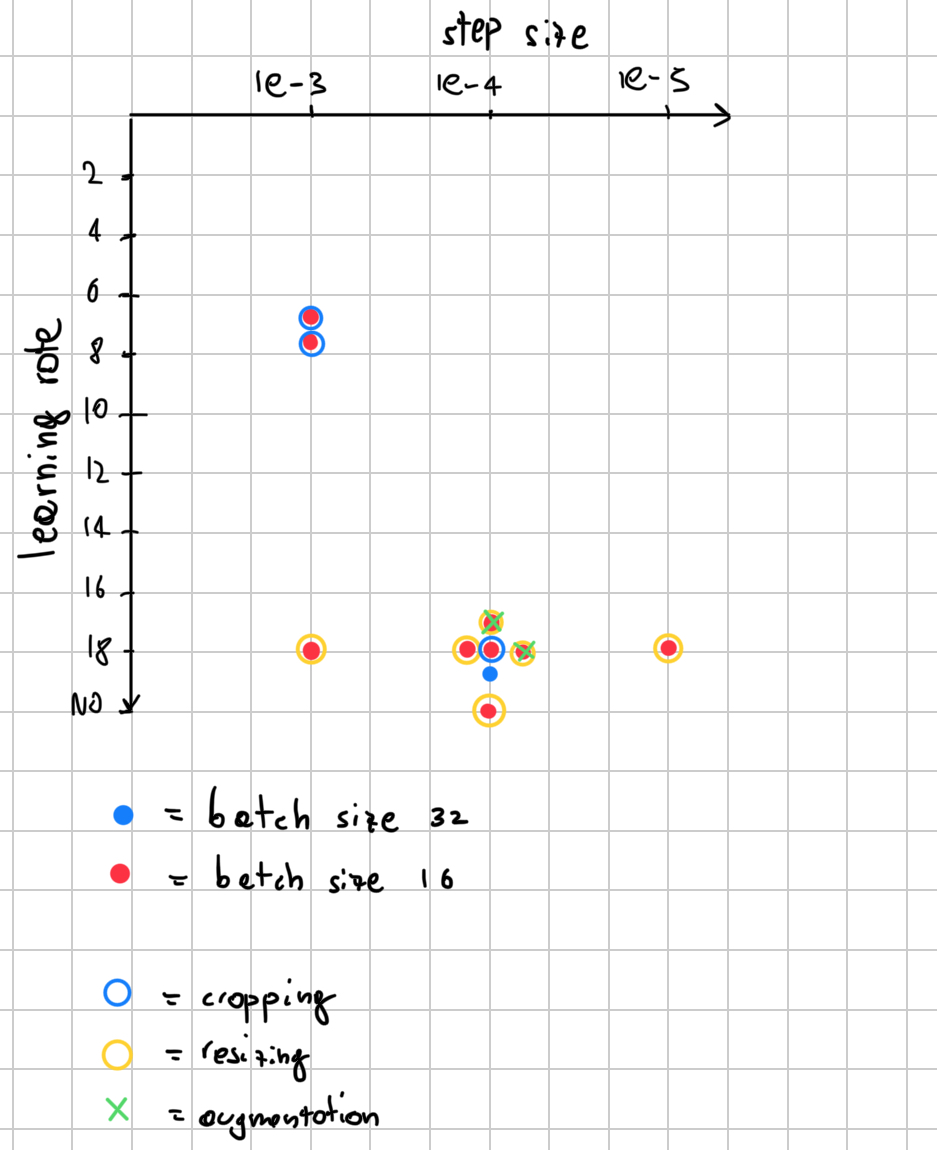

 Ho provato anche altri odelli cambiando: step size, batch size e le trasformazioni: ho provato con cropping o con resizing e con augmentations o senza. Questo è infine il codice che ho utilizzato per il testing.



In [ ]:
#trasformazioni
test_transform = A.Compose(
      [
          A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
          A.Normalize(
              mean=[0.0,0.0,0.0,0.0],
              std=[1.0,1.0,1.0,1.0],
          ),
          ToTensorV2(),
      ],
  )





def main():

    #lista di directory dei modelli
    model_paths = [
        "/content/drive/My Drive/progettoLabAi3/computations/saved/model14/",
        "/content/drive/My Drive/progettoLabAi3/computations/saved/model11/",
        "/content/drive/My Drive/progettoLabAi3/computations/saved/model4/",
    ]

    models = []

    print("Creazione dataset e dataloader ...")
    test_ds = MultispectralDataset(
            image_dir= TEST_IMG_DIR,
            mask_dir= TEST_MASK_DIR,
            transform= test_transform,
    )


    test_loader = DataLoader(
            test_ds,
            batch_size=BATCH_SIZE,
            num_workers= NUM_WORKERS,
            pin_memory=PIN_MEMORY,
            shuffle=False,
    )

    print("Dataset e dataloader creati !")

    loss_fn = nn.BCEWithLogitsLoss()

    print("Creazione modelli ...")
    for model_path in model_paths:
        model = UNET(in_channels=4, out_channels=1).to(DEVICE)
        load_checkpoint(torch.load(model_path +"my_checkpoint.pth.tar"), model)
        models.append(model)
    print("Modelli creati !")

    print(f"Test dei modelli ...")
    for i in range(0,len(models)):

      model = models[i]
      model_path = model_paths[i]
      print(f"Sto testando il modello {model_path}")
      check_accuracy(
            test_loader,
            model,
            loss_fn,
            file= model_path  +"outputs/test.txt",
            device=DEVICE
      )

      save_predictions_as_imgs(
              test_loader, model, folder=model_path +"images_test/", device=DEVICE
      )

    print("Test terminati !")


if __name__ == "__main__":
  main()